## План
Ничем не отличается от моделирования цены на метр, только мы берем лишь одну категорию: `df = df[df['Кол-во комнат'].isin(['СиА'])]`

**Отчет 2: Влияние факторов на цену за метр у лотов**
* Всё также мы видим, что на нашей выборке самыми значимыми факторами влияющими на **цену предложения на метр^2** на рынке вторичной недвижимости оказываются **район и метро**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
import statsmodels
PATH_TO_PROCESSED_DATA = '../data/'
PATH_TO_IMAGES = '../imgs/'

from collections import defaultdict
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import lightgbm as lgbm
import eli5
import scipy.stats

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv(PATH_TO_PROCESSED_DATA + 'features_dataset.csv', index_col=[0])
target = pd.read_csv(PATH_TO_PROCESSED_DATA + 'target_column.csv', index_col=[0])
print(df.shape)
print(f'{df.memory_usage().sum() / 1024 / 1024 :.2f} Mb')
assert df.shape[0] == target.shape[0]

(14329, 25)
1.98 Mb


In [3]:
df.nunique()

Округ                                 12
Район                                153
Площадь                             1736
Площадь лог                         1736
Кол-во комнат                          7
Этаж                                  73
Этажей в доме                         73
Первый этаж                            2
Последний этаж                         2
Метро                                272
Расстояние до метро (ед)              57
Расстояние указано пешком              2
Расстояние указано на транспорте       2
Тип дома                               7
Указан раздельный санузел              2
Несколько санузлов                     2
Балкон указан                          2
Окна                                   3
Окна во двор                           2
Ремонт                                 4
Наличие ремонта                        2
Возраст дома                         126
Доля жилой площади                  6121
Доля куханной площади               5252
Площадь кухни   

Возьмем лоты нужной категории

In [4]:
# df = df[~df['Кол-во комнат'].isin(['1', '2', '3', '4, ''5', 'МиСП'])]
df = df[df['Кол-во комнат'].isin(['3'])]
target = target.loc[df.index]

### Предобрабатываем

> Закодируем `категориальные признки`: Округ, Район, Метро, Кол-во комнат

In [5]:
df.head(1)

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
2710,НАО (Новомосковский),Коммунарка поселок,41.1,3.716008,3,5.0,24.0,False,False,Ольховая,...,False,False,NaN,False,NaN,True,NaN,0.851582,NaN,NaN


In [6]:
logging.info(f'Предобрабатываем: {df.columns[df.dtypes == "object"].values.tolist()}.')
label_encoder_dict = defaultdict(LabelEncoder)

# допустим, что это в функции
df['Округ'] = df['Округ'].astype(str)
df['Район'] = df['Район'].astype(str)
df['Кол-во комнат'] = df['Кол-во комнат'].astype(str)
df['Метро'] = df['Метро'].astype(str)
df['Тип дома'] = df['Тип дома'].astype(str)
df['Окна'] = df['Окна'].astype(str)
df['Ремонт'] = df['Ремонт'].astype(str)

# df['Доля жилой площади'] = df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median'))
# pd.get_dummies(df, columns=['Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'])
# df['Площадь'] = np.log(df['Площадь'])

cat_columns = df.columns[df.dtypes == 'object']
df[cat_columns] = df[cat_columns].apply(lambda x: label_encoder_dict[x.name].fit_transform(x)).astype('category')
# label_encoder_dict['Округ'].inverse_transform([8])
# df[cat_columns].apply(lambda x: label_encoder_dict[x.name].inverse_transform(x))

logging.info(f'Предобработка: завершение')

INFO:root:Предобрабатываем: ['Округ', 'Район', 'Кол-во комнат', 'Метро', 'Тип дома', 'Окна', 'Ремонт'].
INFO:root:Предобработка: завершение


### Моделируем

> Зависимость `цены за метр^2` от признаков лотов (независимо от кол-ва комнат)

In [7]:
def metrics_report(y_pred : np.array, y_true : np.array):
    '''
    Вывод метрик качества и графика рассеивания
    :input:
        predicted and background truth targets
    :return: 
        R2 and Mean Absolute Errors metrics values
    '''
    r2 = sklearn.metrics.r2_score(y_pred, y_true)
    mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
    mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
    
    plt.scatter(y=y_pred, x=y_true, alpha=0.25);
    plt.ylabel('predicted log(Цена за метр^2)')
    plt.xlabel('log(Цена за метр^2)')
    plt.title('Диаграмма рассеивания (log(ˆp), log(p))')
    
    logging.info(f'R2 = {r2:.2f}; MAE = {mae:.2f}; MSE = {mse:.2f}')
    return r2, mae, mse

In [8]:
cols_not_to_use = ['Площадь', 'Площадь кухни']
target_col = 'Цена за метр^2'

logging.info(f'Моделируем: {target_col}.')
logging.info(f'Не используем: {cols_not_to_use}.')
logging.info(f'Используем: {list(df.columns[~df.columns.isin(cols_not_to_use)])}.')

INFO:root:Моделируем: Цена за метр^2.
INFO:root:Не используем: ['Площадь', 'Площадь кухни'].
INFO:root:Используем: ['Округ', 'Район', 'Площадь лог', 'Кол-во комнат', 'Этаж', 'Этажей в доме', 'Первый этаж', 'Последний этаж', 'Метро', 'Расстояние до метро (ед)', 'Расстояние указано пешком', 'Расстояние указано на транспорте', 'Тип дома', 'Указан раздельный санузел', 'Несколько санузлов', 'Балкон указан', 'Окна', 'Окна во двор', 'Ремонт', 'Наличие ремонта', 'Возраст дома', 'Доля жилой площади', 'Доля куханной площади'].


> * Студия: ```max_depth=7, n_estimators=100, num_leaves=12, reg_alpha=1.1, reg_beta=0.1, importance_type='split', random_state=42```
* И в целом, из-за уменьшения размеров выборки можно еще больше регуляризировать модель, признаки остаются примерно те же.

In [9]:
regressor = lgbm.LGBMRegressor(max_depth=7, n_estimators=100,
                               num_leaves=12, reg_alpha=1.1, reg_beta=0.1,
                               importance_type='split', 
                               random_state=42)

Посмотрим на метрики качества (насколько хорошо наш алгоритм может объяснить имеющиеся данные)

INFO:root:R2 = 0.89; MAE = 0.10; MSE = 0.02


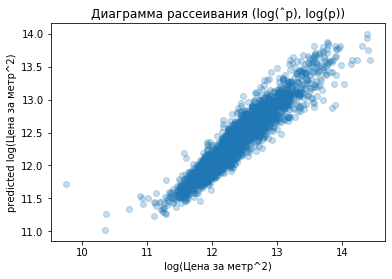

In [10]:
regressor.fit(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
              np.log(target[target_col].values));
metrics_report(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)]),
               np.log(target[target_col].values));

Посмотрим на относительные ошибки

In [11]:
z = np.exp(regressor.predict(df.iloc[:, ~df.columns.isin(cols_not_to_use)])) - target[target_col].values
z = abs(z) / target[target_col].values
z = pd.DataFrame(z, index=df.iloc[:, ~df.columns.isin(cols_not_to_use)].index, columns=['Ошибка'])
z['Кол-во комнат'] = df['Кол-во комнат']
z['Площадь'] = df['Площадь']

z.groupby('Кол-во комнат')['Ошибка'].quantile(0.8)

Кол-во комнат
0    0.151676
Name: Ошибка, dtype: float64

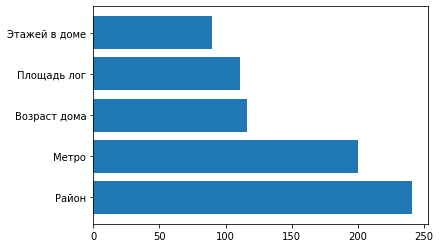

In [12]:
y = df.iloc[:, ~df.columns.isin(cols_not_to_use)].columns[regressor.feature_importances_.argsort()[::-1][:5]]
x = regressor.feature_importances_[regressor.feature_importances_.argsort()[::-1][:5]]
plt.barh(width=x, y=y);

In [13]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.7265,Район
0.1044,Метро
0.0412,Возраст дома
0.0405,Площадь лог
0.0267,Ремонт
0.0185,Этажей в доме
0.0095,Доля куханной площади
0.0084,Округ
0.0072,Этаж
0.0061,Доля жилой площади


In [14]:
eli5.explain_weights_lightgbm(regressor, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2191,Район
0.1818,Метро
0.1055,Возраст дома
0.1009,Площадь лог
0.0818,Этажей в доме
0.0518,Доля куханной площади
0.0445,Ремонт
0.0445,Этаж
0.0391,Доля жилой площади
0.0382,Округ


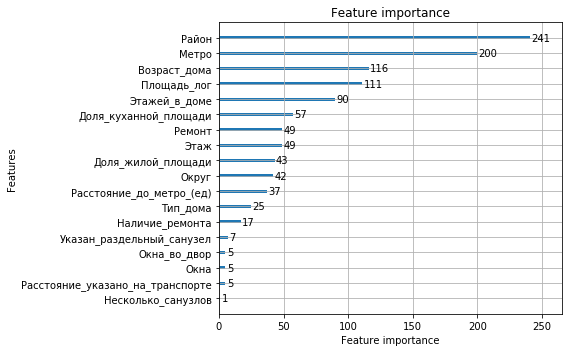

In [15]:
lgbm.plot_importance(regressor, figsize=(8, 5))
plt.tight_layout();

**Вывод:** значения метрик высоки, но 
1. доминирующий вклад вносят от 1-2 до 2-6 признаков
2. метрика качества при такой валидации означает лишь то, насколько хорошо алгоритм смог выучить имеющиеся данные и их закономерности (при определенной трактовке задачи этого может быть достаточно, но на всякий случай проведем валидацию на отложенной выборке, а заодно и более регуляризуем наш алгоритм)

### Посмотрим на более регуляризованную модель, на половине выборки и с разбиением по количеству комнат
> * То есть, мы моделируем ситуацию, когда у нас было ~7000 лотов, а потом пришло еще 7000 тысяч, с примерным сохранением количества комнат*, и мы хотим узнать, насколько хорошо наша модель может объяснить цену на них.  
* Проблемой такого подхода может быть недостаточное количество наблюдений по категориям чтобы построить хорошую модель на них


\* Да, мы знаем, что как минимум раз за 10 лет это распределение сдвигается, на основе статьи (Магнус, Пересецкий), но за 10 лет могут происходить куда более серьезные с точки зрения нашей модели изменения, чем лишь изменение количества комнат в лотах. Например, рост цен в несколько раз относительно цен на которых мы моделировали значимости.

In [16]:
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(df.iloc[:, ~df.columns.isin(cols_not_to_use)], 
                                                                              np.log(target[target_col]), 
                                                                              test_size = 0.5, 
                                                                              shuffle = True, 
                                                                              stratify = df['Кол-во комнат'], 
                                                                              random_state = 891)
train_data = lgbm.Dataset(train_x, label=train_y)
valid_data = lgbm.Dataset(valid_x, label=valid_y)

In [17]:
params = {'metric' : 'mse',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 12,
          'max_depth' : 7,
          'n_estimators' : 100,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 1.1,
          'reg_lambda': 0.1,
          'subsample': 0.855,
          'verbose' : 100,
          'learning_rate' : 0.1,
          'num_threads' : 2}

In [18]:
#Train model on selected parameters and number of iterations
regressor_2 = lgbm.train(params,
                 train_data,
                 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 120,
                 verbose_eval = 500
                 )
regressor_2.booster_ = regressor_2

Training until validation scores don't improve for 120 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0448027


D:\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Посмотрим на метрики качества (насколько хорошо наш, но чуть более строгий алгоритм, мог бы объяснить 'новые' данные с такой же природой)

INFO:root:R2 = 0.69; MAE = 0.15; MSE = 0.04


(0.6875603485630396, 0.15090686375872656, 0.04480265342247914)

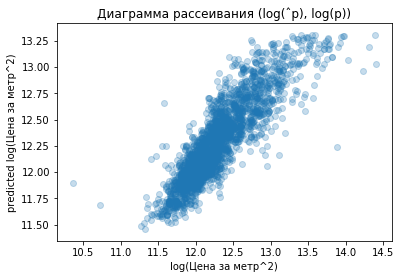

In [19]:
metrics_report(regressor_2.predict(valid_x), valid_y)

Относительные ошибки

In [20]:
z = np.exp(regressor_2.predict(valid_x)) - np.exp(valid_y)
z = abs(z) / np.exp(valid_y)
z = pd.DataFrame(z)
z['Кол-во комнат'] = valid_x['Кол-во комнат']
z['Площадь'] = valid_x['Площадь лог']

z.groupby('Кол-во комнат')['Цена за метр^2'].quantile(0.9)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Кол-во комнат
0    0.317989
Name: Цена за метр^2, dtype: float64

In [21]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='gain')

Weight,Feature
0.7045,Район
0.1001,Метро
0.0840,Округ
0.0381,Площадь лог
0.0267,Ремонт
0.0131,Возраст дома
0.0095,Доля куханной площади
0.0072,Тип дома
0.0067,Этаж
0.0029,Расстояние до метро (ед)


In [22]:
eli5.explain_weights_lightgbm(regressor_2, vec=None, top=20, 
                         target_names=None, 
                         targets=None, 
                         feature_names=df.columns[~df.columns.isin(cols_not_to_use)].values, 
                         feature_re=None, 
                         feature_filter=None, 
                         importance_type='split')

Weight,Feature
0.2976,Район
0.1548,Метро
0.1500,Округ
0.0881,Ремонт
0.0524,Возраст дома
0.0500,Доля куханной площади
0.0476,Площадь лог
0.0381,Расстояние до метро (ед)
0.0310,Этаж
0.0286,Тип дома


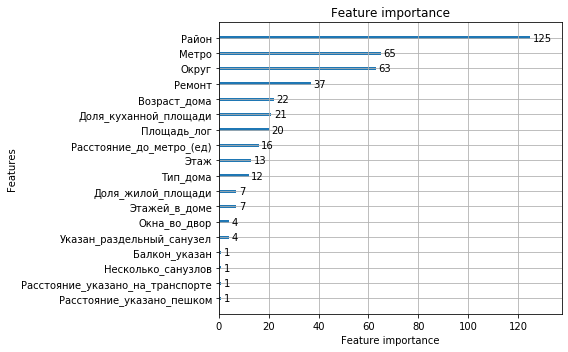

In [23]:
lgbm.plot_importance(regressor_2, importance_type='split', figsize=(8, 5))
plt.tight_layout()

**Вывод:** значения метрик ожидаемо стали хуже (например, R^2 упал, значение метрики относительной ошибки прогноза выросло), но 
1. модель теперь более регуляризована по признакам и искусственно недостигает точки остановы по критерию отсутствия изменения метрики качества (для этого нужно добавить деревьев, но увеличить риск уменьшения обобщающей спобосности)
2. мы не контроллировали разбиения по другим категориальным признакам, только по числу комнат, это может быть и вероятно есть критично для данных этой структуры (высокое количество районов, высокое количество пропусков в некоторых полях) 
3. самые значимые признаки всё равно остаются неизменными.

### Рассмотрим связи признаков после моделирования

> Посмотрим на связь признаков
* Корреляции Пирсона для количественным и Спирмана для качественных

* *Логорифм от площади взят, чтобы сгладить выбросы цены на графике и не удалять их*

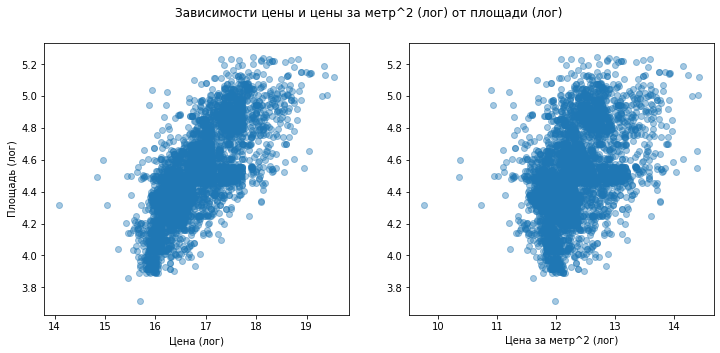

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от площади (лог)')
ax[0].scatter(x=np.log(target['Цена'].values), y=np.log(df['Площадь'].values), alpha=0.4)
ax[1].scatter(x=np.log(target['Цена за метр^2'].values), y=np.log(df['Площадь'].values), alpha=0.4)

ax[0].set_ylabel('Площадь (лог)')
ax[0].set_xlabel('Цена (лог)')
ax[1].set_xlabel('Цена за метр^2 (лог)')


plt.savefig(PATH_TO_IMAGES + 
            f'Цена на метр^2 от площади {label_encoder_dict["Кол-во комнат"].inverse_transform(df["Кол-во комнат"].unique())[0]}_комнат.jpg')

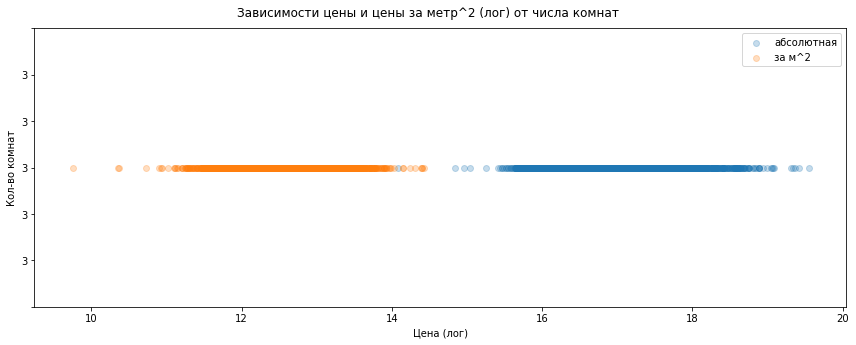

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости цены и цены за метр^2 (лог) от числа комнат')
ax.scatter(x=np.log(target['Цена'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='абсолютная')
ax.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.25, label='за м^2')
#plt.scatter(x=np.log(target['Цена за метр^2'].values), y=df['Кол-во комнат'].values, alpha=0.4)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);

ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Цена (лог)');
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

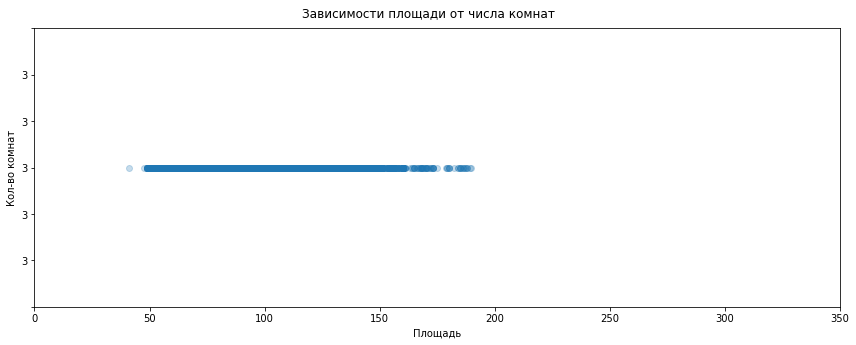

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.suptitle('Зависимости площади от числа комнат')
ax.scatter(x=df['Площадь'].values, y=df['Кол-во комнат'].values, alpha=0.25)
ticks = [label_encoder_dict['Кол-во комнат'].inverse_transform([int(tick)])[0] for tick in plt.yticks()[0].tolist()[1:-1]]
plt.yticks(plt.yticks()[0], [''] + ticks + ['']);
ax.set_ylabel('Кол-во комнат')
ax.set_xlabel('Площадь');
ax.set_xlim(0, 350)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Интересные характеристики лотов
* Наличие более одного санузла, сильнее связано с площадью, чем с количеством комнат. А площадь уже связано с количеством комнат.
* Число этажей обратно пропорционально возрасту дома. Наверное, это ожидаемо, при учете медианного возраста дома в $20$ лет ($18$ без обработки пропусков), а медианного количества этажей в доме равного $16$

In [27]:
scipy.stats.spearmanr(df['Кол-во комнат'].values, df['Несколько санузлов'].values)

C:\Users\Vitaly\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Vitaly\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SpearmanrResult(correlation=nan, pvalue=nan)

In [28]:
scipy.stats.spearmanr(df['Площадь'].values, df['Несколько санузлов'].values)

SpearmanrResult(correlation=0.5286699641317933, pvalue=0.0)

In [29]:
scipy.stats.spearmanr(df['Площадь'].values, df['Кол-во комнат'].values)

SpearmanrResult(correlation=nan, pvalue=nan)

In [30]:
scipy.stats.spearmanr(df['Этажей в доме'].values,
                      df['Возраст дома'].fillna(df.groupby(['Кол-во комнат'])['Возраст дома'].transform('median')))

SpearmanrResult(correlation=-0.5243166485563694, pvalue=0.0)

* Район сильнее связан как с абсолютной ценой, так и с ценой за метр квадратный, чем округ

In [31]:
df['Возраст дома'].fillna(df.groupby('Кол-во комнат')['Возраст дома'].transform('median')).values

array([18., 46., 57., ...,  5., 10., 18.])

In [32]:
scipy.stats.spearmanr(df['Район'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.22970658748212194, pvalue=6.877492785054373e-63)

In [33]:
scipy.stats.spearmanr(df['Метро'].values, target.astype(int)['Цена'].values)

SpearmanrResult(correlation=0.11128812914168067, pvalue=1.0095041404176584e-15)

* По не ясной причине, доля куханной площади обратно пропорционально площади. Возможно, дело в количестве пропусков и том, что мы не имеем полной картины 

In [34]:
np.corrcoef(df['Площадь'].values, 
            df['Доля жилой площади'].fillna(df.groupby('Кол-во комнат')['Доля жилой площади'].transform('median')))

array([[ 1.        , -0.28029251],
       [-0.28029251,  1.        ]])

In [35]:
np.corrcoef(df['Площадь'].values, 
            df['Доля куханной площади'].fillna(df.groupby('Кол-во комнат')['Доля куханной площади'].transform('median')))

array([[1.        , 0.10422748],
       [0.10422748, 1.        ]])

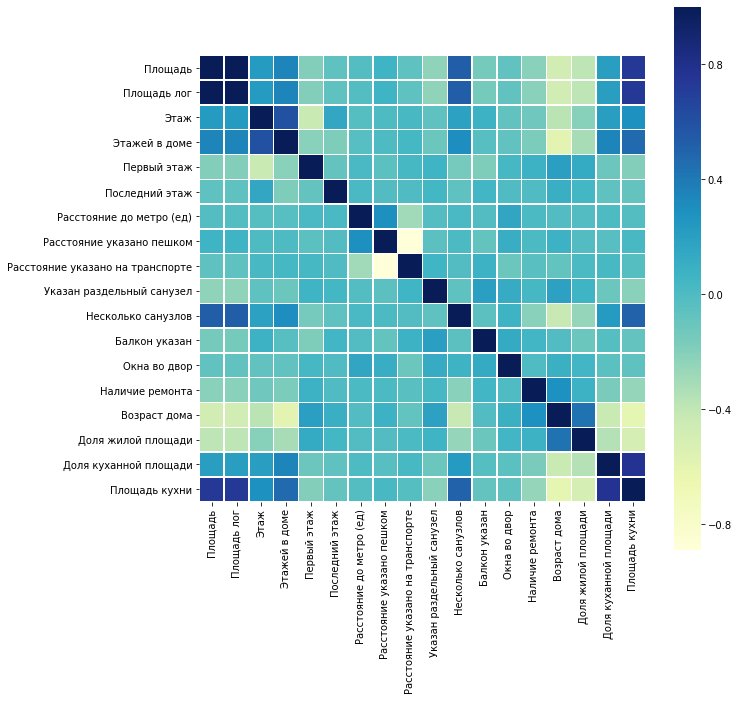

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(method='spearman'), linewidth=0.5, square=True,  cmap="YlGnBu")

plt.savefig(PATH_TO_IMAGES + 'Матрица корреляции признаков')

> Посмотрим на еще один способ изучить значимость признаков
* SHAP

In [37]:
import shap

Wall time: 0 ns


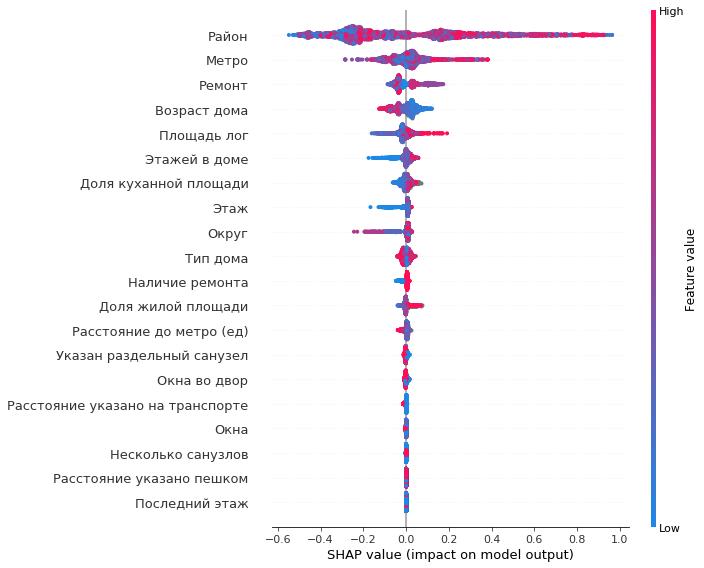

In [38]:
%time
# https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
# https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/
# https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(df.iloc[:, ~df.columns.isin(cols_not_to_use)])
shap.summary_plot(shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

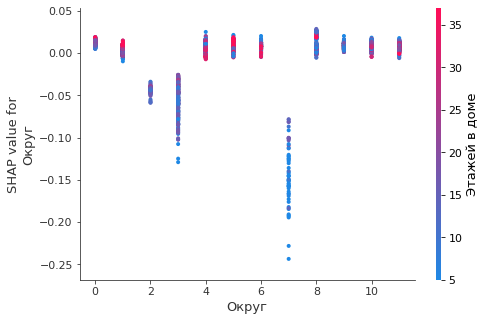

In [39]:
shap.dependence_plot("Округ", shap_values, df.iloc[:, ~df.columns.isin(cols_not_to_use)])

In [40]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0:1], 
                df.iloc[:, ~df.columns.isin(cols_not_to_use)][0:1])

In [41]:
df.iloc[:, :][0:1]

,Округ,Район,Площадь,Площадь лог,Кол-во комнат,Этаж,Этажей в доме,Первый этаж,Последний этаж,Метро,...,Несколько санузлов,Балкон указан,Окна,Окна во двор,Ремонт,Наличие ремонта,Возраст дома,Доля жилой площади,Доля куханной площади,Площадь кухни
2710,3,9,41.1,3.716008,0,5.0,24.0,False,False,143,...,False,False,0,False,0,True,NaN,0.851582,NaN,NaN


In [42]:
label_encoder_dict['Кол-во комнат'].inverse_transform([0])

array(['3'], dtype=object)

In [43]:
label_encoder_dict['Округ'].inverse_transform([0])

array(['ВАО'], dtype=object)

In [44]:
label_encoder_dict['Метро'].inverse_transform([159])

array(['Печатники'], dtype=object)